<a href="https://colab.research.google.com/github/ccg-esb-lab/ARCfitness/blob/main/MonodGillespieARC_2_synthetic_library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re
import time
import copy
import pickle
from dataclasses import dataclass


from pathlib import Path, Path as P
from pathlib import Path
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch, Ellipse
from matplotlib.ticker import MultipleLocator
from numpy.linalg import lstsq


import matplotlib.image as mpimg


plt.rcParams.update({
    "axes.labelsize": 16,   # fontsize for axis labels
    "xtick.labelsize": 14,  # fontsize for x-axis tick labels
    "ytick.labelsize": 14   # fontsize for y-axis tick labels
})

## Set experimental parameters

Model parameters:

In [2]:
initial_resource = 1.0
simulation_time = 24.0
B0=1e6
od2cells = 1e9

ref_family=''
ref_key='pMBA'

Simulation parameters:

In [3]:
def make_switch_schedule(first_env="G", switch_day=10, num_days=30, second_env="E"):
    if switch_day < 0 or switch_day > num_days:
        raise ValueError("switch_day must be in [0, num_days]")
    return [first_env] * switch_day + [second_env] * (num_days - switch_day)


In [4]:
#labels_of_interest = ["ereA2", "aacA7", "OXA10", "dfrA31","qacE","OXA1","OXA118","fosF", "BEL1", "GES1", "IMP2", "IMP31", "OXA129","OXA196", "VIM2", "VIM7", "dfrA6", "dfrB2", "aphA16", "aadB", "fosC2", "fosE", "fosG", "fosH", "fosI", "fosK", "fosL", "fosM", "fosN"]
#families=['dfr', 'bla', 'aa', 'mix']

n_syn=100
family = 'all'

labels_of_interest = ["ereA2", "aacA7", "OXA10", "dfrA31","qacE"]
base_families=['all','dfr', 'bla', 'aa', 'mix']

exportData=True
simulateData=True


In [7]:

num_days = 14
K=7 # Day when switch to aerobiosis is performed
sched_name = 'Switch_K%s'%K

schedule = make_switch_schedule(first_env="G", switch_day=K, num_days=num_days, second_env="E")

E_color = "#B63E36"   # aerobiosis (anaerobiosis)
G_color = "#EBDD99"   # anaerobiosis (aerobiosis)

Ks_to_show = [25, 50, 75]

## Clone GitHub Repo

In [8]:


repo_url = "https://github.com/ccg-esb-lab/ARCfitness.git"
repo_name = "ARCfitness"

if not Path(repo_name).exists():
    !git clone {repo_url}

REPO_ROOT = Path(repo_name).resolve()
print("Repo root:", REPO_ROOT)

# Create local folders for figures and processed simulations.
pathCODE = REPO_ROOT / "code"
pathFIGURES = REPO_ROOT / "figures"
pathSIM = REPO_ROOT / "sim"

pathFIGURES.mkdir(parents=True, exist_ok=True)
pathSIM.mkdir(parents=True, exist_ok=True)



Repo root: /content/ARCfitness


___

In [9]:
def load_all_fits(csv_path, min_r2=0.9):
    """
    Load fitted parameters from a CSV file and build a lookup map.

    Parameters:
    - csv_path: path to the CSV created by save_fit_to_csv.
    - min_r2: minimum R2 threshold applied if the column exists.

    Returns:
    - fits_df: DataFrame of all fits (optionally filtered by R2).
    - param_map: dict keyed by (family, strain) with fitted parameters.
    """
    fits_df = pd.read_csv(csv_path).dropna(how="all").dropna(axis=1, how="all")
    if fits_df.empty:
        raise ValueError(f"No rows in '{csv_path}'.")

    fits_df["family"] = fits_df["family"].astype("string")
    fits_df["strain"] = fits_df["strain"].astype("string")

    if "R2" in fits_df.columns:
        fits_df = fits_df[fits_df["R2"] >= min_r2].reset_index(drop=True)

    param_map = {}
    for _, r in fits_df.iterrows():
        key = (str(r["family"]), str(r["strain"]))
        param_map[key] = {
            "Vmax": float(r["Vmax"]),
            "K": float(r["K"]),
            "c": float(r["c"]),
            "N0": float(r.get("N0_cells", 2e8)),
            "R2": float(r.get("R2", np.nan)),
        }

    return fits_df, param_map


def get_params(fits_df, family, strain):
    """
    Retrieve the first matching parameter set for a given strain and family.
    If family is an empty string or None, match only on strain.
    """
    if family:
        row = fits_df[(fits_df["family"] == family) & (fits_df["strain"] == strain)]
    else:
        row = fits_df[fits_df["strain"] == strain]

    if row.empty:
        raise ValueError(f"No parameters found for {strain} ({family if family else 'any family'})")

    return {
        "Vmax": float(row["Vmax"].iloc[0]),
        "K": float(row["K"].iloc[0]),
        "c": float(row["c"].iloc[0]),
    }


min_r2 = 0.9
csv_path = REPO_ROOT / "data" / "params_fits.csv"

fits_df, PARAMS = load_all_fits(csv_path, min_r2=min_r2)
print(f"Loaded {len(PARAMS)} fitted strains with R² >= {min_r2}.")

ref_key = ("", "pMBA")
p0 = get_params(fits_df, ref_key[0], ref_key[1])
print(f"p0={p0}")

p0_df = pd.DataFrame(
    {
        "V": [p0["Vmax"], p0["Vmax"]],
        "K": [p0["K"], p0["K"]],
        "c": [p0["c"], p0["c"]],
    },
    index=["E", "G"],
)


Loaded 115 fitted strains with R² >= 0.9.
p0={'Vmax': 0.9454613328, 'K': 1.999008188, 'c': 1.0699679e-09}


In [10]:
def _norm(s):
    return re.sub(r"[^a-z0-9]+", "", str(s).lower())


def load_exp_fitness_csv(csv_path):
    """
    Load experimental fitness from a CSV export.

    Parameters:
    - csv_path: path to a CSV with columns ARC and either mean, or replicate columns named as digits.

    Returns:
    - DataFrame with columns strain, w_exp, _key.
    """
    df = pd.read_csv(csv_path).dropna(how="all").dropna(axis=1, how="all")

    rep_cols = [c for c in df.columns if str(c).strip().isdigit()]

    if "mean" in df.columns:
        df["w_exp"] = pd.to_numeric(df["mean"], errors="coerce")
    else:
        df["w_exp"] = pd.to_numeric(df[rep_cols], errors="coerce").mean(axis=1)

    df = df.rename(columns={"ARC": "strain"}).dropna(subset=["strain", "w_exp"])
    df["_key"] = df["strain"].map(_norm)

    return df[["strain", "w_exp", "_key"]]


fitness_aero = load_exp_fitness_csv(REPO_ROOT / "data" / "ARC_fitness_aerobiosis.csv")
print(fitness_aero.head())

fitness_anaero = load_exp_fitness_csv(REPO_ROOT / "data" / "ARC_fitness_anaerobiosis.csv")
print(fitness_anaero.head())


   strain     w_exp    _key
0    VIM1  0.691702    vim1
1    VIM2  0.713427    vim2
2    OXA2  0.731454    oxa2
3  OXA118  0.733002  oxa118
4   IMP31  0.733117   imp31
   strain     w_exp    _key
0   dfrA1  0.931405   dfra1
1   dfrA5  0.965603   dfra5
2   dfrA6  0.910117   dfra6
3   dfrA7  0.858955   dfra7
4  dfrA12  0.937613  dfra12


In [11]:
def load_exp_fitness(csv_path, strain_col="ARC"):
    """Collapse replicates and return numeric mean and SD."""
    df = pd.read_csv(csv_path).dropna(how="all").dropna(axis=1, how="all")

    rep_cols = [c for c in df.columns if str(c).strip().isdigit()]

    df["w_exp"] = (
        pd.to_numeric(df["mean"], errors="coerce")
        if "mean" in df.columns
        else pd.to_numeric(df[rep_cols], errors="coerce").mean(axis=1)
    )

    df["w_exp_std"] = (
        pd.to_numeric(df["desvest"], errors="coerce")
        if "desvest" in df.columns
        else pd.to_numeric(df[rep_cols], errors="coerce").std(axis=1, ddof=1)
    )

    df = df.rename(columns={strain_col: "strain"}) \
           .dropna(subset=["strain", "w_exp"])

    df["_key"] = df["strain"].map(_norm)

    return df[["strain", "w_exp", "w_exp_std", "_key"]]


fitness_aero   = load_exp_fitness(REPO_ROOT / "data" / "ARC_fitness_aerobiosis.csv")
fitness_anaero = load_exp_fitness(REPO_ROOT / "data" / "ARC_fitness_anaerobiosis.csv")


In [12]:

# --- normalizer reused everywhere ---
def _norm(s):
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())


def attach_family_to_exp(exp_df, fits_df, verbose=True, preview_n=10):
    import re
    def _norm(s): return re.sub(r'[^a-z0-9]+', '', str(s).lower())

    exp = exp_df.copy()
    fits = fits_df[['family','strain']].dropna(subset=['strain','family']).copy()

    # Dedup fits by exact strain first
    fits_dedup = fits.drop_duplicates(subset=['strain'], keep='first')

    if verbose:
        print(f"[attach] exp rows: {len(exp)}, fits rows: {len(fits)}, fits unique strains: {fits_dedup['strain'].nunique()}")

    # 1) exact merge
    merged = exp.merge(fits_dedup, on='strain', how='left', suffixes=('', '_fit_exact'))

    # 2) rescue with normalized key, but build a clean key->family map
    needs_rescue = merged['family'].isna()
    if needs_rescue.any():
        fits_key = fits.copy()
        fits_key['_key'] = fits_key['strain'].map(_norm)
        fits_key = fits_key.dropna(subset=['_key'])
        # keep first occurrence per normalized key to avoid many-to-many
        fits_key = fits_key.drop_duplicates(subset=['_key'], keep='first')

        key2fam = dict(zip(fits_key['_key'], fits_key['family']))
        merged['_key'] = merged['strain'].map(_norm)
        merged.loc[needs_rescue, 'family'] = merged.loc[needs_rescue, '_key'].map(key2fam)


    return merged.drop(columns=['_key'], errors='ignore')



# --- aggregate by family: simple mean/std across ARCs belonging to that family ---
def family_fitness_stats(exp_with_family_df, family):
    sub = exp_with_family_df[exp_with_family_df['family'] == family].dropna(subset=['w_exp'])
    if sub.empty:
        raise ValueError(f"No experimental fitness rows found for family '{family}'.")
    # simple across-ARC stats
    mean_w = float(sub['w_exp'].mean())
    std_w  = float(sub['w_exp'].std(ddof=1)) if len(sub) > 1 else float('nan')
    n      = int(len(sub))
    # optional: weighted mean using ARC-level std (if you prefer)
    if sub['w_exp_std'].notna().all() and (sub['w_exp_std'] > 0).any():
        w = 1.0 / (sub['w_exp_std']**2).replace([pd.NA, 0], pd.NA)
        if w.notna().any():
            w_mean = float((w * sub['w_exp']).sum() / w.sum())
        else:
            w_mean = mean_w
    else:
        w_mean = mean_w
    return {
        'family': family,
        'n_ARCs': n,
        'mean_w_exp': mean_w,
        'std_w_exp': std_w,
        'weighted_mean_w_exp': w_mean,
        'strains': (sub['strain'].unique().tolist())
    }

def get_family_w_exp(sheet, family, tab='fitness_aerobiosis', min_r2=0.9):
    exp = load_exp_fitness(sheet, tab=tab)
    fits_df, _ = load_all_fits(sheet, tab="params_fits", min_r2=min_r2)
    exp_wfam = attach_family_to_exp(exp, fits_df)
    return family_fitness_stats(exp_wfam, family)


def get_family_strains_and_stats(exp_wfam, family):
    sub = exp_wfam[exp_wfam['family'] == family].dropna(subset=['w_exp'])
    if sub.empty:
        raise ValueError(f"No experimental fitness data for family {family}")
    return {
        'family': family,
        'strains': sub['strain'].tolist(),
        'w_exp': sub['w_exp'].tolist(),
        'mean_w_exp': float(sub['w_exp'].mean()),
        'std_w_exp': float(sub['w_exp'].std(ddof=1)) if len(sub) > 1 else float('nan'),
        'n': len(sub)
    }

def get_family_exp_stats(family, fits_df, fitness_exp):
    """
    Given a family, the fits_df (with family/strain mapping),
    and the experimental fitness dataframe (with w_exp, w_exp_std),
    return ARC-level values and family-level summary.
    """
    # 1) Get all ARCs (strains) belonging to this family
    strains = fits_df.loc[fits_df['family'] == family, 'strain'].unique()

    rows = []
    for s in strains:
        val = fitness_exp.loc[fitness_exp['strain'] == s, ['w_exp', 'w_exp_std']]
        if not val.empty:
            mu_w, sigma_w = val.iloc[0,0], val.iloc[0,1]
            rows.append({'strain': s, 'w_exp': mu_w, 'w_exp_std': sigma_w})

    df_family = pd.DataFrame(rows)

    # 2) Family-level mean & std across ARCs
    mean_w = df_family['w_exp'].mean() if not df_family.empty else np.nan
    std_w  = df_family['w_exp'].std(ddof=1) if len(df_family) > 1 else np.nan

    return df_family, mean_w, std_w





In [13]:
def load_paired_family_exp(sheet, family,
                           tab_E='fitness_aerobiosis',
                           tab_G='fitness_anaerobiosis',
                           min_r2=0.9):
    # Load experimental fitness for E and G
    exp_E = load_exp_fitness(sheet, tab=tab_E)      # columns: strain, w_exp, w_exp_std, _key
    exp_G = load_exp_fitness(sheet, tab=tab_G)      # same columns
    fits_df, _ = load_all_fits(sheet, tab="params_fits", min_r2=min_r2)

    # attach family to both
    exp_E_fam = attach_family_to_exp(exp_E, fits_df)
    exp_G_fam = attach_family_to_exp(exp_G, fits_df)

    # filter family only if NOT 'all'
    if family != 'all':
        exp_E_fam = exp_E_fam[exp_E_fam['family'] == family]
        exp_G_fam = exp_G_fam[exp_G_fam['family'] == family]

    paired = pd.merge(
        exp_E_fam[['strain','w_exp','w_exp_std']].rename(columns={'w_exp':'w_E','w_exp_std':'w_E_std'}),
        exp_G_fam[['strain','w_exp','w_exp_std']].rename(columns={'w_exp':'w_G','w_exp_std':'w_G_std'}),
        on='strain',
        how='inner'
    ).dropna(subset=['w_E','w_G'])

    print(f"[load_paired_family_exp] family={family}, paired rows={len(paired)}")
    return paired


def estimate_family_bivariate_params(paired_df, shrink_r=0.05, ridge=1e-6):
    """
    Return mean vector, stds, correlation, and covariance matrix.
    shrink_r: convex combination with 0 to stabilize small-n correlations.
    ridge: diagonal jitter for numerical stability.
    """
    if paired_df.empty or paired_df['w_E'].count() < 3:
        # Not enough paired data: signal to fallback
        return None

    wE = paired_df['w_E'].astype(float).values
    wG = paired_df['w_G'].astype(float).values

    mu_E = float(np.mean(wE))
    mu_G = float(np.mean(wG))
    sd_E = float(np.std(wE, ddof=1)) if len(wE) > 1 else 0.0
    sd_G = float(np.std(wG, ddof=1)) if len(wG) > 1 else 0.0

    if sd_E == 0.0 or sd_G == 0.0:
        rho_hat = 0.0
    else:
        rho_hat = float(np.corrcoef(wE, wG)[0,1])

    # light shrinkage of correlation toward 0 to avoid overfitting with small n
    rho = (1.0 - shrink_r) * rho_hat

    cov = np.array([[sd_E**2, rho*sd_E*sd_G],
                    [rho*sd_E*sd_G, sd_G**2]], dtype=float)
    cov.flat[::3] += ridge  # add ridge to diagonal

    return {'mu': np.array([mu_E, mu_G], dtype=float),
            'sd': (sd_E, sd_G),
            'rho': rho,
            'cov': cov}

def sample_bivariate_w(n, mu, cov, clip_min=None, clip_max=None, seed=None):
    rng = np.random.default_rng(seed)
    samples = rng.multivariate_normal(mean=mu, cov=cov, size=n)
    if clip_min is not None or clip_max is not None:
        if clip_min is None: clip_min = -np.inf
        if clip_max is None: clip_max =  np.inf
        samples = np.clip(samples, clip_min, clip_max)
    # returns array shape (n,2): columns [w_E, w_G]
    return samples


def build_synthetic_targets_for_family(sheet, family, n=1000,
                                       tab_E='fitness_aerobiosis',
                                       tab_G='fitness_anaerobiosis',
                                       min_r2=0.9,
                                       clip_range=(0.05, 3.0),
                                       seed=None):
    """
    Returns DataFrame with n target pairs (w_E, w_G) for given family,
    using bivariate Normal if paired data available; otherwise independent marginals.
    """
    paired = load_paired_family_exp(sheet, family, tab_E=tab_E, tab_G=tab_G, min_r2=min_r2)
    stats = estimate_family_bivariate_params(paired)

    if stats is not None:
        samp = sample_bivariate_w(n, stats['mu'], stats['cov'],
                                  clip_min=clip_range[0], clip_max=clip_range[1],
                                  seed=seed)
        out = pd.DataFrame(samp, columns=['w_E_target','w_G_target'])
        out['family'] = family
        out['method'] = 'bivariate'
        out['rho_used'] = stats['rho']
        return out

    # Fallback: independent marginals
    exp_E = load_exp_fitness(sheet, tab=tab_E)
    exp_G = load_exp_fitness(sheet, tab=tab_G)
    fits_df, _ = load_all_fits(sheet, tab="params_fits", min_r2=min_r2)
    exp_E_fam = attach_family_to_exp(exp_E, fits_df)
    exp_G_fam = attach_family_to_exp(exp_G, fits_df)

    if family != 'all':
        subE = exp_E_fam[exp_E_fam['family'] == family]['w_exp'].dropna().values
        subG = exp_G_fam[exp_G_fam['family'] == family]['w_exp'].dropna().values
    else:
        # pooled over all families
        subE = exp_E_fam['w_exp'].dropna().values
        subG = exp_G_fam['w_exp'].dropna().values

    muE, sdE = float(np.mean(subE)), float(np.std(subE, ddof=1)) if len(subE)>1 else 0.0
    muG, sdG = float(np.mean(subG)), float(np.std(subG, ddof=1)) if len(subG)>1 else 0.0

    rng = np.random.default_rng(seed)
    wE = rng.normal(muE, sdE, size=n)
    wG = rng.normal(muG, sdG, size=n)
    if clip_range is not None:
        wE = np.clip(wE, clip_range[0], clip_range[1])
        wG = np.clip(wG, clip_range[0], clip_range[1])

    out = pd.DataFrame({'w_E_target': wE, 'w_G_target': wG,
                        'family': family, 'method': 'marginals', 'rho_used': 0.0})
    return out



In [14]:

def _ellipse_axis_aligned(ax, x, y, nsig_levels=(1,2), color='black', alpha=0.8, lw=1.5):
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 2:  # need at least 2 points for std
        return
    mu_x, mu_y = np.nanmean(x), np.nanmean(y)
    sx = np.nanstd(x, ddof=1) if x.size >= 2 else 0.0
    sy = np.nanstd(y, ddof=1) if y.size >= 2 else 0.0
    if not (np.isfinite(sx) and np.isfinite(sy)) or (sx == 0 and sy == 0):
        return
    for nsig in nsig_levels:
        w = 2 * nsig * sx
        h = 2 * nsig * sy
        if w > 0 and h > 0:
            ax.add_patch(Ellipse((mu_x, mu_y), width=w, height=h, angle=0.0,
                                 edgecolor=color, facecolor='none', lw=lw, alpha=alpha, zorder=3))

def _ellipse_rotated(ax, x, y, nsig_levels=(1,2), color='black', alpha=0.8, lw=1.5):
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 3:  # covariance needs ≥3 for stable ddof=1
        return
    mu_x, mu_y = np.nanmean(x), np.nanmean(y)
    cov = np.cov(np.vstack([x, y]), ddof=1)
    if not np.all(np.isfinite(cov)):
        return
    vals, vecs = np.linalg.eigh(cov)          # ascending eigenvalues
    vals = np.clip(vals, 0.0, None)           # numeric safety
    angle_deg = np.degrees(np.arctan2(vecs[1,1], vecs[0,1]))  # major axis angle
    for nsig in nsig_levels:
        w = 2 * nsig * np.sqrt(vals[1])       # major axis
        h = 2 * nsig * np.sqrt(vals[0])       # minor axis
        if np.isfinite(w) and np.isfinite(h) and w > 0 and h > 0:
            ax.add_patch(Ellipse((mu_x, mu_y), width=w, height=h, angle=angle_deg,
                                 edgecolor=color, facecolor='none', lw=lw, alpha=alpha, zorder=3))


def plot_w_scatter(
    df_env,
    family=None,
    highlight=None,
    annotate=None,
    *,
    ellipse_mode='rotated',      # 'axis' | 'rotated' | 'auto'
    corr_threshold=0.2,          # only for ellipse_mode='auto'
    nsig_levels=(1,2),
    ellipse_color='#666666',
    ellipse_alpha=0.8,
    ellipse_lw=1.5,
    family_colors=None,          # dict like {'bla':'#1f77b4', ...}; used if family=None
    pathFIGURES='',
    ax=None
):
    """
    Scatter of relative fitness (w) in anaerobiosis (G, x-axis) vs aerobiosis (E, y-axis),
    per label, with covariance ellipses.

    df_env must have columns:
        ['label','Environment','achieved_w','family'].

    If `family` is not None:
        - Subset df_env to that family and plot it as a single cloud.
        - Draw a single ellipse on that cloud.

    If `family` is None:
        - Assume df_env may contain multiple families.
        - Plot each family in a different color.
        - Draw one ellipse per family (using that family's color).
        - Title is generic and we include a legend.

    highlight : list-like of labels to highlight (drawn on top, yellow)
    annotate  : list-like of labels to annotate with text

    Returns:
        A dict mapping family_name -> pivot_dataframe, where each pivot_dataframe
        has columns ['label','G','E','family'].
        In single-family mode, it's a dict with one key.
    """

    # defaults
    highlight = set(highlight or [])
    annotate  = set(annotate or [])

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
        created_fig = True

    def _pivot_one_family(df_sub, fam_name):
        """
        df_sub: rows of a SINGLE family
        returns pivot with columns ['label','G','E','family'] if possible
        """
        pivot = (
            df_sub.pivot_table(
                index="label",
                columns="Environment",
                values="achieved_w",
                aggfunc="mean"
            )
            .reset_index()
        )

        # Check that both environments we want are present
        missing_envs = [env for env in ['G', 'E'] if env not in pivot.columns]
        if missing_envs:
            # No paired G/E values for this family → nothing to plot
            return pd.DataFrame(columns=["label", "G", "E", "family"])

        # Drop rows that do not have BOTH E and G
        pivot = pivot.dropna(subset=['G', 'E'], how='any')

        if pivot.empty:
            return pd.DataFrame(columns=["label", "G", "E", "family"])

        pivot['family'] = fam_name
        return pivot[['label', 'G', 'E', 'family']]


    # branch 1: single family mode
    if family is not None:
        df_use = df_env[df_env['family'] == family].copy()
        if df_use.empty:
            raise ValueError(f"No rows found for family '{family}'.")

        pivot = _pivot_one_family(df_use, family)
        if pivot.empty:
            raise ValueError(f"Family '{family}' has no paired E/G fitness values.")

        # base scatter for this family
        x = pivot['G'].astype(float).to_numpy()
        y = pivot['E'].astype(float).to_numpy()
        ax.scatter(x, y, color='grey', alpha=0.2, s=20)

        # highlight subset (true experimental strains or strains of interest)
        if highlight:
            df_hl = pivot[pivot['label'].isin(highlight)]
            ax.scatter(df_hl['G'], df_hl['E'], color='yellow', alpha=0.7, s=20)

        # annotate subset
        if annotate:
            df_ann = pivot[pivot['label'].isin(annotate)]
            ax.scatter(df_ann['G'], df_ann['E'], color='red', alpha=0.8)
            for _, row in df_ann.iterrows():
                ax.text(
                    float(row['G']) + 0.01,
                    float(row['E']),
                    row['label'],
                    fontsize=9,
                    ha='left',
                    va='center',
                    color='red'
                )

        # choose ellipse mode
        _draw_ellipse_for_points(
            ax, x, y,
            ellipse_mode=ellipse_mode,
            corr_threshold=corr_threshold,
            nsig_levels=nsig_levels,
            ellipse_color=ellipse_color,
            ellipse_alpha=ellipse_alpha,
            ellipse_lw=ellipse_lw
        )

        # axis formatting
        ax.set_xlim(0.5, 1.5)
        ax.set_ylim(0.5, 1.5)
        ax.set_aspect('equal', adjustable='box')
        ax.axhline(1, color='black', linestyle='--', alpha=0.7)
        ax.axvline(1, color='black', linestyle='--', alpha=0.7)
        ax.set_xlabel("Relative fitness (anaerobiosis)")
        ax.set_ylabel("Relative fitness (aerobiosis)")
        ax.set_title(family.upper())

        # save/show if standalone
        if created_fig:
            plt.tight_layout()
            if pathFIGURES:
                filename = f"{pathFIGURES}/w_scatter_{family}.png"
                plt.savefig(filename, format='png', bbox_inches='tight')
                print(f"Exporting {filename}")
            plt.show()

        return {family: pivot}

    # branch 2: multi-family overlay mode
    # -----------------------------------
    fam_results = {}
    fam_list = sorted(df_env['family'].dropna().unique().tolist())
    if family_colors is None:
        # fallback palette
        default_cols = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']
        family_colors = {f: default_cols[i % len(default_cols)] for i, f in enumerate(fam_list)}

    for fam_name in fam_list:
        df_sub = df_env[df_env['family'] == fam_name].copy()
        if df_sub.empty:
            continue

        pivot_f = _pivot_one_family(df_sub, fam_name)
        if pivot_f.empty:
            continue

        fam_results[fam_name] = pivot_f

        x = pivot_f['G'].astype(float).to_numpy()
        y = pivot_f['E'].astype(float).to_numpy()
        col = family_colors.get(fam_name, 'gray')

        # scatter for this family
        ax.scatter(
            x, y,
            s=20,
            alpha=0.4,
            color=col
        )

        # annotate/highlight logic could optionally be family-specific;
        # here we apply globally:
        if highlight:
            df_hl = pivot_f[pivot_f['label'].isin(highlight)]
            if not df_hl.empty:
                ax.scatter(df_hl['G'], df_hl['E'], color='yellow', alpha=0.7, s=20)
        if annotate:
            df_ann = pivot_f[pivot_f['label'].isin(annotate)]
            if not df_ann.empty:
                ax.scatter(df_ann['G'], df_ann['E'], color='red', alpha=0.8)
                for _, row in df_ann.iterrows():
                    ax.text(
                        float(row['G']) + 0.01,
                        float(row['E']),
                        row['label'],
                        fontsize=9,
                        ha='left',
                        va='center',
                        color='red'
                    )

        # ellipse for this family, in that family's color but transparent
        _draw_ellipse_for_points(
            ax, x, y,
            ellipse_mode=ellipse_mode,
            corr_threshold=corr_threshold,
            nsig_levels=nsig_levels,
            ellipse_color=col,
            ellipse_alpha=0.15,        # lighter fill for multi-family
            ellipse_lw=1.5
        )

    # common axis formatting for overlay
    ax.set_xlim(0.5, 1.5)
    ax.set_ylim(0.5, 1.5)
    ax.set_aspect('equal', adjustable='box')
    ax.axhline(1, color='black', linestyle='--', alpha=0.7)
    ax.axvline(1, color='black', linestyle='--', alpha=0.7)
    ax.set_xlabel("Relative fitness (anaerobiosis)")
    ax.set_ylabel("Relative fitness (aerobiosis)")
    ax.set_title("Relative fitness across families")
    ax.legend(frameon=False)

    if created_fig:
        plt.tight_layout()
        if pathFIGURES:
            filename = f"{pathFIGURES}/w_scatter_allfamilies.png"
            plt.savefig(filename, format='png', bbox_inches='tight', dpi=300)
            print(f"Exporting {filename}")
        plt.show()

    return fam_results


def _draw_ellipse_for_points(
    ax, x, y,
    *,
    ellipse_mode,
    corr_threshold,
    nsig_levels,
    ellipse_color,
    ellipse_alpha,
    ellipse_lw
):
    """
    Chooses axis-aligned vs rotated ellipse based on mode and corr.
    Calls your existing _ellipse_axis_aligned / _ellipse_rotated.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    mode = ellipse_mode.lower()
    if mode == 'axis':
        _ellipse_axis_aligned(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)
        return

    if mode == 'rotated':
        _ellipse_rotated(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)
        return

    # auto mode
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() >= 2:
        corr = np.corrcoef(x[mask], y[mask])[0,1]
    else:
        corr = np.nan

    if np.isfinite(corr) and abs(corr) >= float(corr_threshold):
        _ellipse_rotated(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)
    else:
        _ellipse_axis_aligned(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)



In [16]:
print(pathCODE)

/content/ARCfitness/code


In [15]:
import sys, importlib
sys.path.append(pathCODE)

import MonodGillespieMI
importlib.reload(MonodGillespieMI)
MG = MonodGillespieMI

import MonodGillespieMI_IO
IO = MonodGillespieMI_IO
importlib.reload(MonodGillespieMI_IO)


ModuleNotFoundError: No module named 'MonodGillespieMI'

In [ ]:
def p0_from_df(p0_df, env):
    """
    Read reference parameters from a small table indexed by environment.

    Parameters:
    - p0_df: DataFrame indexed by env with columns V, K, c.
    - env: environment label (e.g., "E" or "G").

    Returns:
    - dict with keys Vmax, K, c.
    """
    row = p0_df.loc[env]
    return {
        "Vmax": float(row["V"]),
        "K": float(row["K"]),
        "c": float(row["c"]),
    }


p0_E = p0_from_df(p0_df, "E")
p0_G = p0_from_df(p0_df, "G")


def load_fitness_family_csv(csv_path, family):
    """
    Load a fitness results table from CSV and filter to one family label.

    Parameters:
    - csv_path: path to the exported fitness_<family>.csv file.
    - family: family label to match exactly in column 'family'.

    Returns:
    - DataFrame filtered to the requested family.
    """
    df = pd.read_csv(csv_path).dropna(how="all").dropna(axis=1, how="all")

    if "family" not in df.columns:
        raise ValueError("Missing required column 'family'.")

    df_env = df[df["family"] == family].reset_index(drop=True)
    return df_env


csv_path = REPO_ROOT / "data" / f"fitness_{family}.csv"
df_env = load_fitness_family_csv(csv_path, family)

print(f"[{family}] df_env shape:", df_env.shape)
print(df_env)


[all] df_env shape: (4242, 13)
       label      Vmax        K             c  target_w  achieved_w   abs_err  \
0     aacA16  0.927615  1.99647  1.257342e-09  0.891030    0.891023  0.000008   
1     aacA16  0.927264  1.99647  1.095091e-09  0.888185    0.887001  0.001184   
2      aacA2  0.957278  1.99647  1.137995e-09  1.090478    1.089795  0.000684   
3      aacA2  0.948225  1.99647  1.140258e-09  1.025404    1.023802  0.001602   
4     aacA27  0.957773  1.99647  1.117449e-09  1.094007    1.094588  0.000581   
...      ...       ...      ...           ...       ...         ...       ...   
4237  x_1118  0.931201  1.99647  1.025738e-09  0.911338    0.912831  0.001493   
4238  x_1119  0.947294  1.99647  1.239174e-09  1.018227    1.018013  0.000214   
4239  x_1119  0.931022  1.99647  1.165441e-09  0.911730    0.911618  0.000112   
4240  x_1120  0.920989  1.99647  1.281228e-09  0.849318    0.849904  0.000586   
4241  x_1120  0.944962  1.99647  1.153840e-09  1.003020    1.002277  0.000743 

In [ ]:
from scipy.optimize import minimize


syn_targets = build_synthetic_targets_for_family(
    fitness_aero_csv=REPO_ROOT / "data" / "fitness_aerobiosis.csv",
    fitness_anaero_csv=REPO_ROOT / "data" / "fitness_anaerobiosis.csv",
    fits_csv=REPO_ROOT / "data" / "fits_parameters.csv",
    family=family,
    n=n_syn,
    min_r2=0.9,
    clip_range=(0.05, 3.0),
    seed=123,
)


if "pair_idx" in df_env.columns and df_env["pair_idx"].notna().any():
    start_idx = int(df_env["pair_idx"].max()) + 1
else:
    start_idx = 0


TypeError: build_synthetic_targets_for_family() got an unexpected keyword argument 'fitness_aero_csv'

### Simple Gillespie Model ($\tau$-leaping)

In [ ]:
def gillespie_bacterial_growth_batch(strains, initial_resource, simulation_time,  dt=0.1, num_simulations=3):
    """
    Simulates bacterial growth with multiple mutant levels, resource limitation, and adeath
    using a batch update approach. Runs multiple simulations and returns the mean population size.

    Parameters:
    - strains (list of dict): List of strain dictionaries with parameters:
        - 'initial_population' (float): Initial population size.
        - 'Vmax' (float): Birth rate.
        - 'death_rate' (float): Base death rate.
        - 'K' (float): Half-saturation constant for resource consumption.
        - 'c' (float): Resource consumption rate per birth event.
    - initial_resource (float): Initial resource level.
    - simulation_time (float): Maximum simulation time.
    - dt (float): Time step for batch updates.
    - num_simulations (int): Number of independent simulations to average.

    Returns:
    - t_values (list): Time points where changes occurred.
    - mean_population_values (list of lists): Mean population sizes of each strain at corresponding time points.
    - mean_R_values (list): Mean resource levels at corresponding time points.
    """

    all_t_values = []
    all_population_values = []
    all_R_values = []

    for sim in range(num_simulations):
        # Initialize time and populations
        t = 0
        populations = [strain['initial_population'] for strain in strains]
        R = initial_resource

        # Record initial conditions
        t_values = [t]
        population_values = [populations[:]]
        R_values = [R]

        while t < simulation_time:
            # Check for extinction or resource depletion
            if sum(populations) <= 0 or R <= 0:
                t += dt
                t_values.append(t)
                population_values.append(populations[:])
                R_values.append(R)
                continue

            # Calculate birth and death events for each strain
            births = [
                np.random.poisson(strain['Vmax'] * populations[i] * (R / (R + strain['K'])) * dt)
                for i, strain in enumerate(strains)
            ]


            # Update populations and resources after birth and death events
            for i in range(len(populations)):
                populations[i] += births[i] #- deaths[i]

            # Decrease resource based on total births across strains
            total_resource_consumption = sum(births[i] * strains[i]['c'] for i in range(len(strains)))
            R -= total_resource_consumption

            # Ensure populations and resources are non-negative
            populations = [max(0, pop) for pop in populations]
            R = max(R, 0)

            # Advance time and record results
            t += dt
            t_values.append(t)
            population_values.append(populations[:])
            R_values.append(R)

        # Store results from this simulation
        all_t_values.append(t_values)
        all_population_values.append(population_values)
        all_R_values.append(R_values)

    # Convert lists to NumPy arrays for averaging
    all_t_values = np.array(all_t_values)
    all_population_values = np.array(all_population_values)
    all_R_values = np.array(all_R_values)

    # Compute mean results across simulations
    mean_t_values = np.mean(all_t_values, axis=0)
    mean_population_values = np.mean(all_population_values, axis=0)
    mean_R_values = np.mean(all_R_values, axis=0)

    return mean_t_values, mean_population_values, mean_R_values


In [ ]:

def plotSimulation(time_points, population_values, resource, pathFIGURES='',title=''):
    """
    Plots the results of the simulation for all strains and resource depletion using a blues colormap.
    The wild-type strain is plotted in black, and the colormap for mutants skips the first (white) color.

    Parameters:
    time_points (list): Time points from the simulation.
    population_values (list of list): Population sizes of each strain at corresponding time points.
    resource (list): Resource levels over time.
    """
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)

    # Get the number of strains (only one type of population without plasmid-free/plasmid-bearing distinction)
    num_strains = len(population_values[0])

    # Define a colormap (Blues)
    cmap = plt.get_cmap('Blues')

    # Plot populations: wild-type in black, mutants in shades of blue
    for i in range(num_strains):
        linestyle = '-' if i == 0 else '--'  # Wild-type solid, mutants dashed
        color = 'black' if i == 0 else cmap(i / num_strains)
        axes[0].plot(time_points, [(pop[i]) for pop in population_values], label=f'Strain {i}', color=color, linestyle=linestyle)

    axes[0].set_xlabel('Time (hours)', fontsize=14)
    axes[0].set_ylabel('Population', fontsize=14)
    axes[0].set_yscale('log')  # Apply log scale to the population plot
    axes[0].tick_params(axis='both', labelsize=12)

    # Plot resource depletion
    axes[1].plot(time_points, resource, color='orange', label='Resource')
    axes[1].set_xlabel('Time (hours)', fontsize=14)
    axes[1].set_ylabel('Resource concentration', fontsize=14)
    axes[1].tick_params(axis='both', labelsize=12)
    axes[1].set_ylim([0, 1.1])


    if pathFIGURES != '':
            filename = f"{pathFIGURES}simulation_{title}.png"
            plt.savefig(filename, format='png')
            print("Exporting %s" % filename)
    plt.show()




---



## Competition experiment

In [ ]:
# --- Build two-strain inputs from raw parameter dicts ---
def make_two_strain_params_from_dicts(pA, pB, *,
                                      freqA0=0.5, Ntot0=2e8,
                                      death_rate=0.0, A_half=0.5):
    """
    pA, pB: dicts with {'Vmax','K','c'} (N0 is ignored here).
    Returns the 'strains' list ready for the simulator.
    """
    NA0 = float(Ntot0) * float(freqA0)
    NB0 = float(Ntot0) - NA0
    strains = [
        {'Vmax': float(pA['Vmax']),
         'death_rate': float(death_rate),
         'initial_population': float(NA0),
         'K': float(pA['K']),
         'c': float(pA['c']),
         'A_half': float(A_half)},
        {'Vmax': float(pB['Vmax']),
         'death_rate': float(death_rate),
         'initial_population': float(NB0),
         'K': float(pB['K']),
         'c': float(pB['c']),
         'A_half': float(A_half)},
    ]
    return strains

# --- Single competition runner  ---
def run_competition_once(sim_fn, strains, initial_resource, simulation_time):
    out = sim_fn(strains=strains,
                 initial_resource=initial_resource,
                 simulation_time=simulation_time)
    import numpy as np
    if len(out) == 2:
        t, pops = out; res = None
    else:
        t, pops, res = out
    return np.asarray(t, float), np.asarray(pops, float), res

In [ ]:
def plot_competition(result, labels=None, colors=("C0","C1"), ylog=False, title=None, pathFIGURES=''):
    import matplotlib.pyplot as plt
    import numpy as np

    t = result['time']; pops = result['pops']

    # Try to get names from result (old path), else fall back
    famA = strainA = famB = strainB = None
    if 'keyA' in result and 'keyB' in result:
        try:
            (famA, strainA), (famB, strainB) = result['keyA'], result['keyB']
        except Exception:
            pass

    # Final labels
    if labels is None:
        if strainA is not None and strainB is not None:
            labels = (f"{strainA} ({famA})", f"{strainB} ({famB})")
        else:
            labels = ("Strain A", "Strain B")

    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=False)

    # --- Left panel: population dynamics ---
    ax = axes[0]

    # Style: grey dotted if name contains 'pMBA'; otherwise colored solid
    def _style_for(name, color):
        if name and ("pmba" in name.lower()):
            return dict(color="0.5", ls=":", lw=2)
        return dict(color=color, ls="-", lw=2)

    styleA = _style_for(labels[0], colors[0])
    styleB = _style_for(labels[1], colors[1])

    ax.plot(t, pops[:,0], label=labels[0], **styleA)
    ax.plot(t, pops[:,1], label=labels[1], **styleB)

    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Cells/mL")
    if ylog:
        ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False)

    # --- Right panel: log ratio ---
    ax2 = axes[1]
    with np.errstate(divide='ignore', invalid='ignore'):
        lnratio = np.log(np.maximum(pops[:,0],1e-12)/np.maximum(pops[:,1],1e-12))
    ax2.plot(t, lnratio, '-', color='k', lw=1.8)
    ax2.axhline(0, color='0.7', lw=1)
    ax2.set_xlabel("Time (hours)")
    ax2.set_ylabel("ln(N_A / N_B)")
    ax2.grid(True, alpha=0.3)

    if title:
        fig.suptitle(title)

    plt.tight_layout()

    if pathFIGURES != '':
            filename = f"{pathFIGURES}competition_{title}.png"
            plt.savefig(filename, format='png')
            print("Exporting %s" % filename)
    plt.show()
    return axes



### Calibration

In [ ]:
import numpy as np
from scipy.optimize import minimize

K_FIXED = 1.99647

def make_scaled_params(p0_env, mult_V=1.0, mult_c=1.0, K_fixed=K_FIXED):
    """
    Scale V and c, keep K fixed.
    p0_env is a dict with keys: 'Vmax', 'K', 'c'
    """
    return {
        "Vmax": float(p0_env["Vmax"]) * float(mult_V),
        "K": float(K_fixed),
        "c": float(p0_env["c"]) * float(mult_c),
    }


In [ ]:
def run_pairwise_competition(sim_fn,
                             initial_resource, simulation_time,
                             *,
                             pA, pB,
                             freqA0=0.5, Ntot0=1e6,
                             death_rate=0.0, A_half=0.5):
    strains = make_two_strain_params_from_dicts(
        pA, pB, freqA0=freqA0, Ntot0=Ntot0,
        death_rate=death_rate, A_half=A_half
    )
    t, pops, res = run_competition_once(sim_fn, strains, initial_resource, simulation_time)

    mets = competition_metrics(t, pops)

    return {
        'pA': pA, 'pB': pB,
        'freqA0': freqA0, 'Ntot0': Ntot0,
        'time': t, 'pops': pops, 'resource': res,
        'metrics': mets
    }


def competition_metrics(t, pops):
    """
    Metrics based ONLY on end-of-day densities (no early slope).

    Returns:
      fA_end, fB_end
      lnratio_start, lnratio_end
      w_final : exp( ln(Na/Nb)_end - ln(Na/Nb)_start )
              = (Na_end/Nb_end) / (Na0/Nb0)
    """
    import numpy as np

    Na = np.asarray(pops[:, 0], float)
    Nb = np.asarray(pops[:, 1], float)

    Na0 = float(Na[0])
    Nb0 = float(Nb[0])
    Na_end = float(Na[-1])
    Nb_end = float(Nb[-1])

    # Frequencies at end
    Ntot_end = max(Na_end + Nb_end, 1e-12)
    fA_end = Na_end / Ntot_end
    fB_end = Nb_end / Ntot_end

    # Final-density fitness (ratio-of-ratios)
    eps = 1e-12
    lnratio_start = float(np.log((Na0 + eps) / (Nb0 + eps)))
    lnratio_end   = float(np.log((Na_end + eps) / (Nb_end + eps)))
    w_final = float(np.exp(lnratio_end - lnratio_start))

    return {
        'fA_end': fA_end,
        'fB_end': fB_end,
        'lnratio_start': lnratio_start,
        'lnratio_end': lnratio_end,
        'w_final': w_final
    }


def plot_competition(result, labels=None, colors=("C0","C1"), ylog=False, title=None, pathFIGURES=''):
    import matplotlib.pyplot as plt
    import numpy as np

    t = result['time']; pops = result['pops']

    # Try to get names from result (old path), else fall back
    famA = strainA = famB = strainB = None
    if 'keyA' in result and 'keyB' in result:
        try:
            (famA, strainA), (famB, strainB) = result['keyA'], result['keyB']
        except Exception:
            pass

    # Final labels
    if labels is None:
        if strainA is not None and strainB is not None:
            labels = (f"{strainA} ({famA})", f"{strainB} ({famB})")
        else:
            labels = ("Strain A", "Strain B")

    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=False)

    # --- Left panel: population dynamics ---
    ax = axes[0]

    # Style: grey dotted if name contains 'pMBA'; otherwise colored solid
    def _style_for(name, color):
        if name and ("pmba" in name.lower()):
            return dict(color="0.5", ls=":", lw=2)
        return dict(color=color, ls="-", lw=2)

    styleA = _style_for(labels[0], colors[0])
    styleB = _style_for(labels[1], colors[1])

    ax.plot(t, pops[:,0], label=labels[0], **styleA)
    ax.plot(t, pops[:,1], label=labels[1], **styleB)

    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Cells/mL")
    if ylog:
        ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False)

    # --- Right panel: log ratio ---
    ax2 = axes[1]
    with np.errstate(divide='ignore', invalid='ignore'):
        lnratio = np.log(np.maximum(pops[:,0],1e-12)/np.maximum(pops[:,1],1e-12))
    ax2.plot(t, lnratio, '-', color='k', lw=1.8)
    ax2.axhline(0, color='0.7', lw=1)
    ax2.set_xlabel("Time (hours)")
    ax2.set_ylabel("ln(N_A / N_B)")
    ax2.grid(True, alpha=0.3)

    if title:
        fig.suptitle(title)

    plt.tight_layout()

    if pathFIGURES != '':
            filename = f"{pathFIGURES}competition_{title}.png"
            plt.savefig(filename, format='png')
            print("Exporting %s" % filename)
    plt.show()
    return axes

def params_from_row(row):
    return {
        'Vmax': float(row['Vmax']),
        'K':          float(row['K']),
        'c':          float(row['c'])
    }

def _run_one_day(sim_fn, pA, pB, NA_init, NB_init, initial_resource, hours):
    strains = [
        {'Vmax': pA['Vmax'], 'death_rate': 0.0, 'initial_population': NA_init,
         'K': pA['K'], 'c': pA['c'], 'A_half': 0.5},
        {'Vmax': pB['Vmax'], 'death_rate': 0.0, 'initial_population': NB_init,
         'K': pB['K'], 'c': pB['c'], 'A_half': 0.5},
    ]
    out = sim_fn(
        strains=strains,
        initial_resource=initial_resource,
        simulation_time=hours
    )
    if len(out) == 2:
        t, pops = out; res = None
    else:
        t, pops, res = out
    return np.asarray(t, float), np.asarray(pops, float), res

In [ ]:

# MonodGillespieMI imports (adapt names to how you load the module)
#import MonodGillespieMI as MG
def simulate_fitness_for_params(p_arc,
                                p_ref,
                                *,
                                sim_fn=gillespie_bacterial_growth_batch,
                                initial_resource=1.0,
                                simulation_time=24.0,
                                freqA0=0.5,
                                Ntot0=1e6,
                                n_rep=7,
                                rng_seed=123):
    ws = []
    mets_last = None

    for r in range(n_rep):
        res = run_pairwise_competition(
            sim_fn=sim_fn,
            initial_resource=initial_resource,
            simulation_time=simulation_time,
            pA=p_arc,
            pB=p_ref,
            freqA0=freqA0,
            Ntot0=Ntot0,
            death_rate=0.0,
            A_half=0.5,
        )
        mets_last = res["metrics"]
        w = float(mets_last["w_final"])
        if np.isfinite(w) and w > 0:
            ws.append(w)

    if len(ws) == 0:
        return np.nan, mets_last

    return float(np.mean(ws)), mets_last


def calibrate_one_env_target_Vrho(
    label, family,
    w_target,
    p0_env,
    *,
    sim_fn,
    initial_resource=1.0,
    simulation_time=24.0,
    freqA0=0.5,
    Ntot0=1e6,
    K_fixed=K_FIXED,
    bounds=((0.2, 5.0), (0.05, 20.0)),
    x0=(1.0, 1.0),
    reg_lambda=1e-4,   # weaker than before
    verbose=False,
):
    w_target = float(w_target)
    log_w_target = np.log(max(w_target, 1e-12))

    def loss(theta):
        mult_V, mult_c = float(theta[0]), float(theta[1])

        p_arc = make_scaled_params(p0_env, mult_V=mult_V, mult_c=mult_c, K_fixed=K_fixed)
        w_sim, mets = simulate_fitness_for_params(
            p_arc, p0_env,
            sim_fn=sim_fn,
            initial_resource=initial_resource,
            simulation_time=simulation_time,
            freqA0=freqA0,
            Ntot0=Ntot0,
            n_rep=3,
            rng_seed=123,
        )
        if not np.isfinite(w_sim) or w_sim <= 0:
            return 1e9

        # fit in log-space
        log_w_sim = np.log(max(w_sim, 1e-12))
        err = (log_w_sim - log_w_target)**2

        # light regularization in log-space
        reg = reg_lambda * (np.log(mult_V)**2 + np.log(mult_c)**2)

        return err + reg

    # noise-tolerant optimizer
    res = minimize(loss, x0=np.array(x0, float), bounds=bounds, method="Powell")

    mult_V, mult_c = map(float, res.x)
    best_p = make_scaled_params(p0_env, mult_V=mult_V, mult_c=mult_c, K_fixed=K_fixed)
    best_w, best_mets = simulate_fitness_for_params(
        best_p, p0_env,
        sim_fn=sim_fn,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        freqA0=freqA0,
        Ntot0=Ntot0,
        n_rep=3,       # report with a bit more averaging
        rng_seed=123,
    )

    if verbose:
        print(
            f"label={label}  family={family}  "
            f"target={w_target:.4f}  achieved={best_w:.4f}  "
            f"mult_V={mult_V:.4f} mult_rho={mult_c:.4f}  "
            f"Vmax={best_p['Vmax']:.6g} K={best_p['K']:.6g} c={best_p['c']:.3e}"
        )

    return best_p, float(best_w), (mult_V, mult_c), best_mets, float(res.fun)



def calibrate_arc_for_targets_Vrho(
    label, family,
    w_E_target, w_G_target,
    *,
    p0_E, p0_G,
    sim_fn,
    initial_resource=1.0,
    simulation_time=24.0,
    freqA0=0.5,
    Ntot0=1e6,
    K_fixed=K_FIXED,
    verbose=False
):
    # --- E ---
    pE, wE, (mV_E, mC_E), metsE, lossE = calibrate_one_env_target_Vrho(
        label, family,
        w_E_target, p0_E,
        sim_fn=sim_fn,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        freqA0=freqA0,
        Ntot0=Ntot0,
        K_fixed=K_fixed,
        verbose=verbose
    )
    row_E = {
        "Environment": "E",
        "target_w": float(w_E_target),
        "achieved_w": float(wE),
        "abs_err": abs(float(wE) - float(w_E_target)),
        "loss": float(lossE),
        "mult_V": float(mV_E),
        "mult_rho": float(mC_E),
        **pE,
        **metsE,
    }

    # --- G ---
    pG, wG, (mV_G, mC_G), metsG, lossG = calibrate_one_env_target_Vrho(
        label, family,
        w_G_target, p0_G,
        sim_fn=sim_fn,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        freqA0=freqA0,
        Ntot0=Ntot0,
        K_fixed=K_fixed,
        verbose=verbose
    )
    row_G = {
        "Environment": "G",
        "target_w": float(w_G_target),
        "achieved_w": float(wG),
        "abs_err": abs(float(wG) - float(w_G_target)),
        "loss": float(lossG),
        "mult_V": float(mV_G),
        "mult_rho": float(mC_G),
        **pG,
        **metsG,
    }

    return row_E, row_G


In [ ]:
import numpy as np
import pandas as pd

def is_synthetic_label(s):
    s = str(s)
    return ("_x" in s) or s.startswith("x_")

def needs_fit_empirical(df_env):
    """
    Empirical rows that still need calibration.
    Rule: not synthetic label AND achieved_w missing.
    """
    lab = df_env["label"].astype(str)
    mask_emp = ~lab.apply(is_synthetic_label)

    # treat empty strings as missing too
    ach = df_env.get("achieved_w", pd.Series([np.nan]*len(df_env), index=df_env.index))
    mask_missing = ach.isna() | (ach.astype(str).str.strip() == "")

    return mask_emp & mask_missing

# ---------------------------------------------------------
# 1) Fit empirical rows that have no achieved_w yet
# ---------------------------------------------------------
mask_fit = needs_fit_empirical(df_env)

df_emp_keep = df_env.loc[~mask_fit].copy()
df_emp_tofit = df_env.loc[mask_fit].copy()

print(f"[{family}] empirical rows needing fit:", len(df_emp_tofit))

rows_emp_fitted = []
if len(df_emp_tofit):

    # We assume each label has exactly two rows (E and G) with target_w present.
    # If your sheet uses w_exp instead, change the field names below.
    for label, g in df_emp_tofit.groupby("label", sort=False):

        # pull pair_idx (assume constant within label)
        pair_idx = int(pd.to_numeric(g["pair_idx"], errors="coerce").dropna().iloc[0])

        # target fitness values must exist for both envs
        gE = g.loc[g["Environment"].astype(str).str.upper().str.startswith("E")]
        gG = g.loc[g["Environment"].astype(str).str.upper().str.startswith("G")]

        if gE.empty or gG.empty:
            print(f"[WARN] {label}: missing E or G row, skipping")
            continue

        # choose where target fitness comes from
        # prefer 'target_w' if present, else fallback to 'w_exp'
        def _get_target(grp):
            if "target_w" in grp.columns and grp["target_w"].notna().any():
                return float(grp["target_w"].iloc[0])
            if "w_exp" in grp.columns and grp["w_exp"].notna().any():
                return float(grp["w_exp"].iloc[0])
            raise ValueError(f"{label}: no target fitness column found (need target_w or w_exp)")

        wE = _get_target(gE)
        wG = _get_target(gG)

        row_E, row_G = calibrate_arc_for_targets_Vrho(
            label=label, family=family,
            w_E_target=wE, w_G_target=wG,
            p0_E=p0_E, p0_G=p0_G,
            sim_fn=MG.gillespie_bacterial_growth_batch,
            initial_resource=1.0,
            simulation_time=24.0,
            freqA0=0.5,
            Ntot0=1e6,
            verbose=True
        )

        # keep identifiers consistent
        for r in (row_E, row_G):
            r["label"] = label
            r["family"] = family
            r["pair_idx"] = pair_idx

        rows_emp_fitted.extend([row_E, row_G])

df_emp_fitted = pd.DataFrame(rows_emp_fitted)
print(f"[{family}] newly fitted empirical rows:", len(df_emp_fitted))

# ---------------------------------------------------------
# 2) Fit synthetic targets only if we actually need them
# ---------------------------------------------------------
labels = df_env["label"].astype(str)
has_synthetic_already = labels.apply(is_synthetic_label).any()

#need_syn = (not has_synthetic_already) and ("syn_targets" in locals()) and (syn_targets is not None) and (len(syn_targets) > 0)
n_labels_total = df_env["label"].nunique()
need_syn = n_labels_total < n_syn

print(f"[{family}] has_synthetic_already={has_synthetic_already}, need_syn={need_syn}, n_syn_targets={(len(syn_targets) if 'syn_targets' in locals() and syn_targets is not None else 0)}")

rows_syn = []
if need_syn:
    for k, row in syn_targets.iterrows():
        wE = float(row["w_E_target"])
        wG = float(row["w_G_target"])
        pair_idx = start_idx + k
        label = f"x_{pair_idx:04d}"

        row_E, row_G = calibrate_arc_for_targets_Vrho(
            label=label, family=family,
            w_E_target=wE, w_G_target=wG,
            p0_E=p0_E, p0_G=p0_G,
            sim_fn=MG.gillespie_bacterial_growth_batch,
            initial_resource=1.0,
            simulation_time=24.0,
            freqA0=0.5,
            Ntot0=1e6,
            verbose=True
        )

        for r in (row_E, row_G):
            r["label"] = label
            r["family"] = family
            r["pair_idx"] = pair_idx
            r["method"] = row.get("method", np.nan)
            r["rho_used"] = row.get("rho_used", np.nan)

        rows_syn.extend([row_E, row_G])
else:
    print(f"[{family}] Skipping synthetic calibration (not needed).")

df_syn = pd.DataFrame(rows_syn)

# ---------------------------------------------------------
# 3) Combine: keep old empirical fitted rows + replace missing empirical + append synthetic
# ---------------------------------------------------------
df_env_out = pd.concat(
    [df_emp_keep, df_emp_fitted, df_syn],
    ignore_index=True
)

print("[DEBUG] df_env_out shape:", df_env_out.shape)

df_env = df_env_out

[all] empirical rows needing fit: 0
[all] newly fitted empirical rows: 0
[all] has_synthetic_already=True, need_syn=False, n_syn_targets=1000
[all] Skipping synthetic calibration (not needed).
[DEBUG] df_env_out shape: (4242, 13)


In [ ]:


EXPORT_COLS = [
    "label","Vmax","K","c","target_w","achieved_w","abs_err","loss",
    "fA_end","fB_end","Environment","family","pair_idx",
]

def apply_empirical_fits_inplace(df_env, df_emp_fitted, cols_to_update=EXPORT_COLS):
    """
    Overwrite df_env values for empirical strains that were calibrated,
    matching on (label, Environment). Preserves df_env row order.
    """
    if df_emp_fitted is None or df_emp_fitted.empty:
        return df_env

    df_env = df_env.copy()
    df_fit = df_emp_fitted.copy()

    # Make sure keys exist
    for c in ["label", "Environment"]:
        if c not in df_env.columns or c not in df_fit.columns:
            raise ValueError(f"Missing key column '{c}' in df_env or df_emp_fitted")

    # Index by (label, Environment)
    env_idx = df_env.set_index(["label", "Environment"])
    fit_idx = df_fit.set_index(["label", "Environment"])

    # Only update columns that actually exist in the fitted frame
    upd_cols = [c for c in cols_to_update if c in fit_idx.columns]

    # Overwrite (update only matching rows)
    env_idx.update(fit_idx[upd_cols])

    # Back to normal frame
    return env_idx.reset_index()

def enforce_export_schema(df, export_cols=EXPORT_COLS, keep_extra=False):
    df = df.copy()

    for c in export_cols:
        if c not in df.columns:
            df[c] = np.nan

    out = df[export_cols].copy()

    if keep_extra:
        extras = [c for c in df.columns if c not in export_cols]
        out = pd.concat([out, df[extras]], axis=1)

    return out



did_calibrate = (
    (df_emp_fitted is not None and not df_emp_fitted.empty) or
    (df_syn is not None and not df_syn.empty)
)

if not did_calibrate:
    print(f"[{family}] No calibration performed. Skipping save.")
else:
    # ---------------------------------------------------------
    # 1) Inject empirical calibrated values back into df_env
    # ---------------------------------------------------------
    df_env_updated = apply_empirical_fits_inplace(
        df_env, df_emp_fitted, cols_to_update=EXPORT_COLS
    )

    # ---------------------------------------------------------
    # 2) Merge experimental + synthetic (exp first, syn appended)
    # ---------------------------------------------------------
    df_env_out = pd.concat([df_env_updated, df_syn], ignore_index=True)

    # ---------------------------------------------------------
    # 3) Enforce export schema
    # ---------------------------------------------------------
    df_env_out = enforce_export_schema(
        df_env_out, EXPORT_COLS, keep_extra=False
    )

    print("[DEBUG] df_env_out shape:", df_env_out.shape)
    print("[DEBUG] df_env_out columns:", df_env_out.columns.tolist())

    # ---------------------------------------------------------
    # 4) Save back
    # ---------------------------------------------------------
    TAB_NAME = f"fitness_{family}"
    ws_out = sheet.worksheet(TAB_NAME)

    set_with_dataframe(ws_out, df_env_out, include_index=False)
    print(f"[{family}] Saved df_env_out with fixed schema to worksheet '{TAB_NAME}'.")

    df_env = df_env_out



[all] No calibration performed. Skipping save.


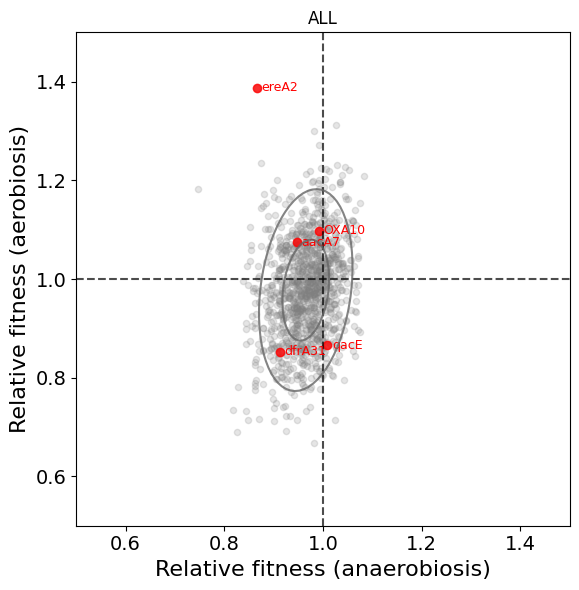

{'all': Environment   label         G         E family
 0              BEL1  0.990551  1.079988    all
 1              GES1  0.972569  1.024418    all
 2              IMP2  0.931890  0.928608    all
 3             IMP31  0.818553  0.733564    all
 4              OXA1  0.892340  1.066926    all
 ...             ...       ...       ...    ...
 1116         x_1116  0.929261  1.024914    all
 1117         x_1117  0.986863  0.971365    all
 1118         x_1118  0.912831  0.886664    all
 1119         x_1119  0.911618  1.018013    all
 1120         x_1120  1.002277  0.849904    all
 
 [1121 rows x 4 columns]}

In [ ]:
# plot directly into subplot axis
plot_w_scatter(
        df_env,
        family=family,
        highlight=[],                # or list of real strains to highlight
        annotate=labels_of_interest, # if defined
        ellipse_mode='rotated',
        pathFIGURES=''
)